 # <font color=green>따릉이 수요 예측 using XGBoost</font>

## 1) 문제정의: 따릉이 대여 수를 예측하는 모델을 생성하려한다.
## 2) 데이터 수집: 서울시 따릉이 데이터
![Image](다운로드.png)

In [1]:
from pytimekr import pytimekr
from datetime import datetime
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

C:\Users\emera\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# 파일 불러오기
df = pd.read_csv('C:/Users/emera/combined_data_with_imputation.csv', index_col= 0)
df.head()

,날짜,시간,D-H,기온,강수량,풍속,습도,기압,전운량,시정,SO2,CO,O3,NO2,PM10,PM25,count
0,2020-01-01,0,2020-01-01-0,-6.5,0.0,0.0,38.0,1022.6,9.0,2000.0,0.004,1.0,0.002,0.047,45.0,33.0,50.0
1,2020-01-01,1,2020-01-01-1,-5.9,0.0,1.7,40.0,1021.8,9.0,2000.0,0.004,0.7,0.002,0.044,25.0,18.0,17.0
2,2020-01-01,2,2020-01-01-2,-5.7,0.0,0.1,42.0,1021.6,9.0,1988.0,0.004,0.7,0.002,0.043,26.0,18.0,30.0
3,2020-01-01,3,2020-01-01-3,-5.6,0.0,0.0,46.0,1021.5,9.0,2000.0,0.004,0.8,0.001,0.043,29.0,20.0,12.0
4,2020-01-01,4,2020-01-01-4,-5.4,0.0,0.0,50.0,1021.6,8.0,1908.0,0.003,0.6,0.002,0.040,26.0,18.0,14.0


## EDA (데이터 탐색)

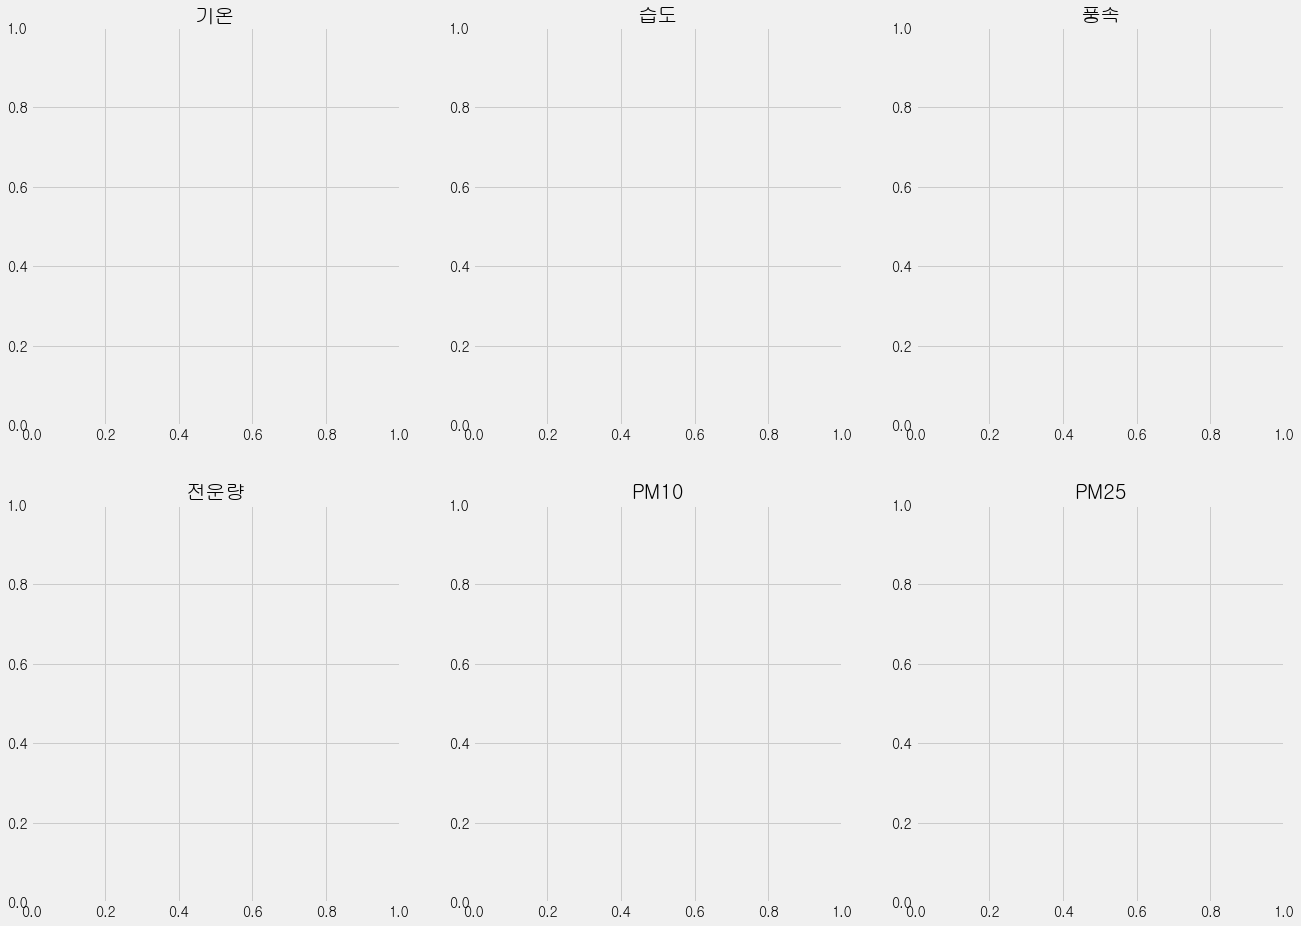

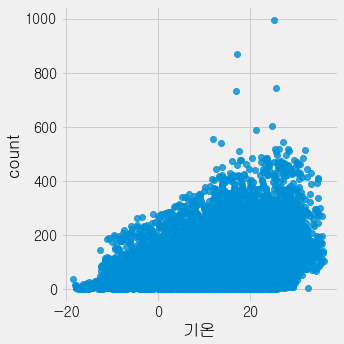

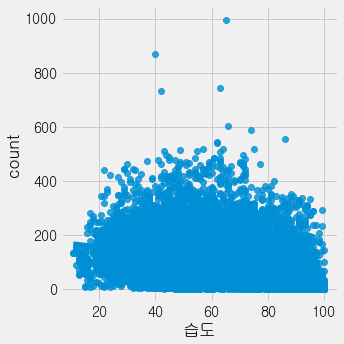

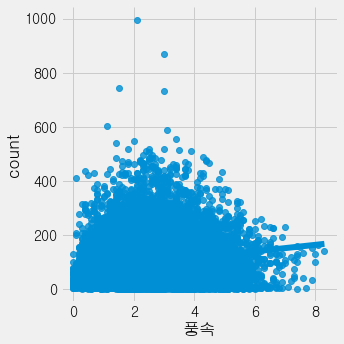

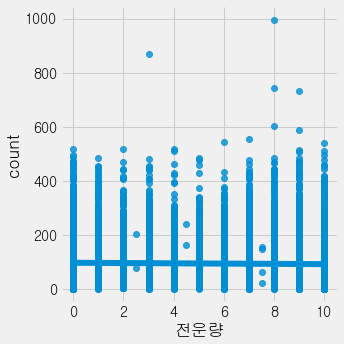

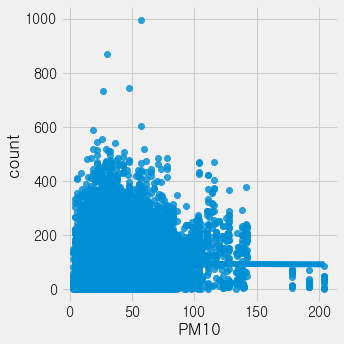

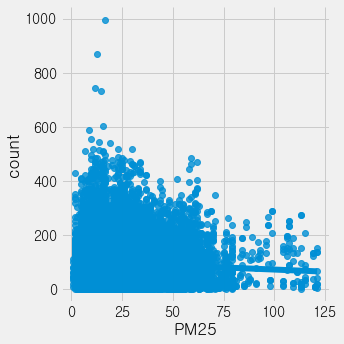

In [3]:
fig = plt.figure(figsize=(20,15))

# title 지정
ax01 = fig.add_subplot(2,3,1)
ax01.set_title('기온')
ax02 = fig.add_subplot(2,3,2)
ax02.set_title('습도')
ax03 = fig.add_subplot(2,3,3)
ax03.set_title('풍속')
ax04 = fig.add_subplot(2,3,4)
ax04.set_title('전운량')
ax05 = fig.add_subplot(2,3,5)
ax05.set_title('PM10')
ax06 = fig.add_subplot(2,3,6)
ax06.set_title('PM25')

# scatter plot
sns.lmplot(x='기온', y='count', data=df)
sns.lmplot(x='습도', y='count', data=df)
sns.lmplot(x='풍속', y='count', data=df)
sns.lmplot(x='전운량', y='count',data=df)
sns.lmplot(x='PM10', y='count',data=df)
sns.lmplot(x='PM25', y='count',data=df)
plt.show()

In [4]:
# 일부 feature 타입 전환 및 수정
df['D-H'] = pd.to_datetime(df['D-H'],format='%Y-%m-%d-%H')
df = df.rename(columns = {'\b기압':'기압'})

### 대여 수 산점도 : 2021년 4월과 10월 사이 극단치 존재

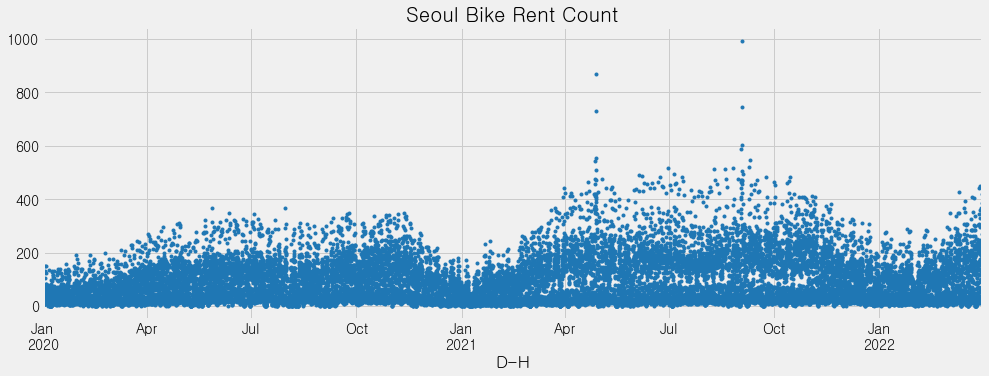

In [5]:
df = df.set_index('D-H')
df['count'].plot(style='.',
                 figsize=(15,5),
                 color=color_pal[0],
                 title='Seoul Bike Rent Count')
plt.show()

#### 대여수 600대 넘은 기간만 조회
2021년 4월 28일 서울에선 별다른 특별한 상황이 파악되지 않음

2021년 9월 2일 서울에선 월드컵 예선 경기가 열렸음

In [6]:
df[df['count']>600]

,날짜,시간,기온,강수량,풍속,습도,기압,전운량,시정,SO2,CO,O3,NO2,PM10,PM25,count
D-H,,,,,,,,,,,,,,,,
2021-04-28 17:00:00,2021-04-28,17,17.1,0.0,3.0,42.0,1005.0,9.0,2000.0,0.003,0.4,0.047,0.010,27.0,15.0,732.0
2021-04-28 18:00:00,2021-04-28,18,17.2,0.0,3.0,40.0,1004.7,3.0,2000.0,0.003,0.4,0.045,0.013,30.0,13.0,870.0
2021-09-02 17:00:00,2021-09-02,17,25.8,0.0,1.5,63.0,998.2,8.0,2000.0,0.004,0.4,0.051,0.011,48.0,12.0,744.0
2021-09-02 18:00:00,2021-09-02,18,25.4,0.0,2.1,65.0,998.3,8.0,2000.0,0.003,0.4,0.049,0.013,57.0,17.0,994.0
2021-09-02 19:00:00,2021-09-02,19,24.9,0.0,1.1,66.0,998.3,8.0,2000.0,0.003,0.5,0.038,0.017,57.0,16.0,603.0


### Feature Engineering: 다양한 정보 탐색

연도, 분기, 달, 요일, 일, 휴일 feature 추가

In [7]:
# 휴일 피처 만들기
hol_2020 = pytimekr.holidays(year=2020)
hol_2021 = pytimekr.holidays(year=2021)
hol_2022 = pytimekr.holidays(year=2022)
holidays = hol_2020 + hol_2021 + hol_2022
holidayss = []
for i in holidays:
    tr = i.strftime('%Y-%m-%d')
    holidayss.append(tr)

In [8]:
# Feature Engineering

def create_features(df):
    df['연도']= df.index.year
    df['분기'] = df.index.quarter
    df['달'] = df.index.month
    df['요일'] = df.index.weekday
    df['주말'] = df['요일'].apply(lambda x: "weekend" if x==5 or x==6 else "weekday")
    df['휴일'] = df['날짜'].apply(lambda x:"Holidays" if x in holidayss else "No Holidays")
    return df

df = create_features(df)

In [9]:
df.head()

,날짜,시간,기온,강수량,풍속,습도,기압,전운량,시정,SO2,...,NO2,PM10,PM25,count,연도,분기,달,요일,주말,휴일
D-H,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,2020-01-01,0,-6.5,0.0,0.0,38.0,1022.6,9.0,2000.0,0.004,...,0.047,45.0,33.0,50.0,2020,1,1,2,weekday,Holidays
2020-01-01 01:00:00,2020-01-01,1,-5.9,0.0,1.7,40.0,1021.8,9.0,2000.0,0.004,...,0.044,25.0,18.0,17.0,2020,1,1,2,weekday,Holidays
2020-01-01 02:00:00,2020-01-01,2,-5.7,0.0,0.1,42.0,1021.6,9.0,1988.0,0.004,...,0.043,26.0,18.0,30.0,2020,1,1,2,weekday,Holidays
2020-01-01 03:00:00,2020-01-01,3,-5.6,0.0,0.0,46.0,1021.5,9.0,2000.0,0.004,...,0.043,29.0,20.0,12.0,2020,1,1,2,weekday,Holidays
2020-01-01 04:00:00,2020-01-01,4,-5.4,0.0,0.0,50.0,1021.6,8.0,1908.0,0.003,...,0.040,26.0,18.0,14.0,2020,1,1,2,weekday,Holidays


#### 1) 시간별 대여수 평균: 
0~5시: 수면 시간대라 대여수가 낮음

6~8시: 출근 시간대라 대여수가 증가함을 알 수 있음

9~16시: 낮 시간대의 평균적인 구간

17~18시: 대여수의 피크구간이며 퇴근시간으로 예상됨

19시~23시: 밤 시간대의 평균적으로 감소하는 구간

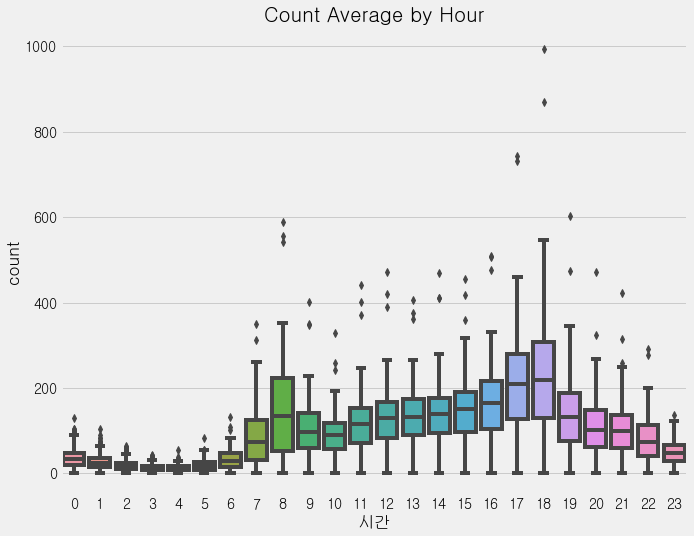

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='시간', y='count')
ax.set_title("Count Average by Hour")
plt.show()

#### 2) 월별 대여수 평균:

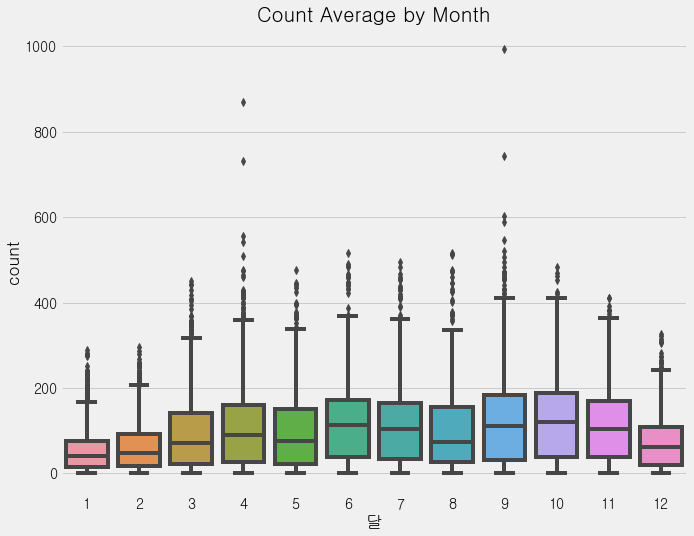

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='달', y='count')
ax.set_title("Count Average by Month")
plt.show()

#### 3) 요일별 대여수 평균:

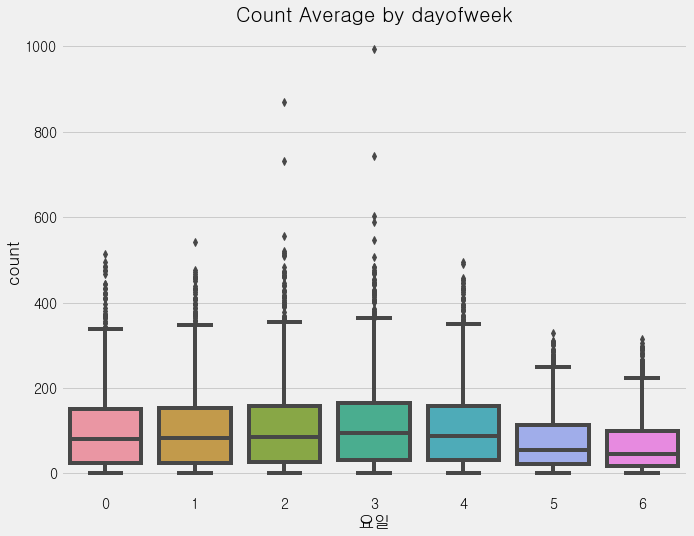

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='요일', y='count')
ax.set_title("Count Average by dayofweek")
plt.show()

#### 4) 분기별 대여수 평균:

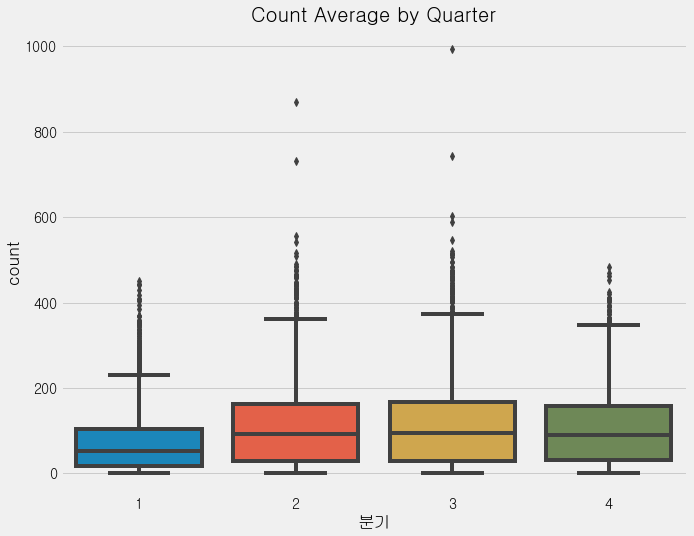

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='분기', y='count')
ax.set_title("Count Average by Quarter")
plt.show()

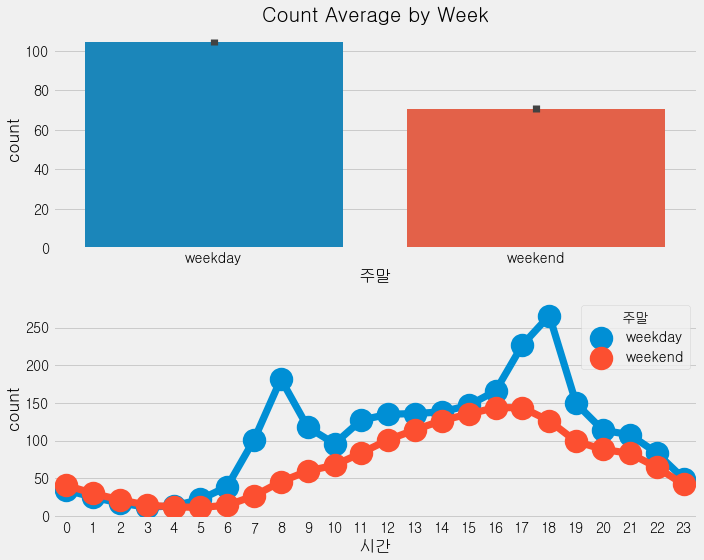

In [14]:
plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
sns.barplot(data=df, x='주말', y='count')
plt.title("Count Average by Week")

plt.subplot(2,1,2)
sns.pointplot(data=df, x='시간',y='count', hue='주말')

plt.tight_layout()
plt.show()

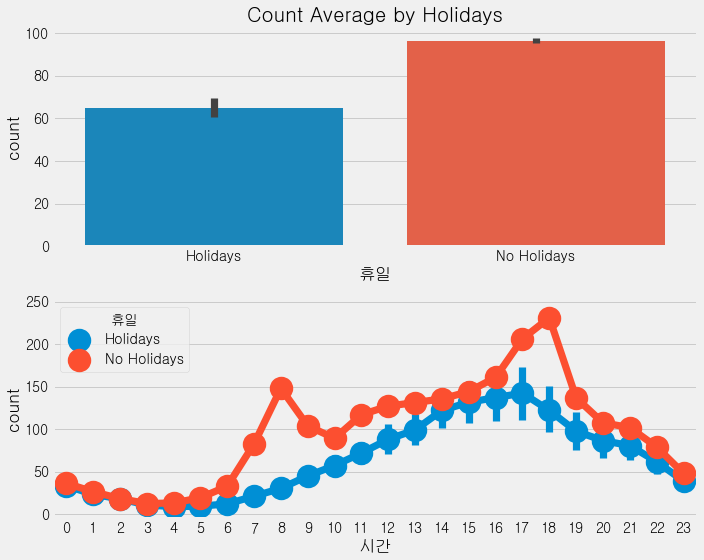

In [15]:
plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
sns.barplot(data=df, x='휴일', y='count')
plt.title("Count Average by Holidays")

plt.subplot(2,1,2)
sns.pointplot(data=df, x='시간',y='count', hue='휴일')

plt.tight_layout()
plt.show()

## 데이터 전처리

#### 다중 공선성 판단
1) 일산화탄소(CO)가 다른 미세먼지 관측값과 높은 상관성이 나타나기에 제외 필요

2) 미세먼지 크기를 나타내는 PM10, PM2.5 간 높은 상관성이 나타나기에 더 큰 집합인 PM10만을 선택

In [16]:
df.head()

,날짜,시간,기온,강수량,풍속,습도,기압,전운량,시정,SO2,...,NO2,PM10,PM25,count,연도,분기,달,요일,주말,휴일
D-H,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,2020-01-01,0,-6.5,0.0,0.0,38.0,1022.6,9.0,2000.0,0.004,...,0.047,45.0,33.0,50.0,2020,1,1,2,weekday,Holidays
2020-01-01 01:00:00,2020-01-01,1,-5.9,0.0,1.7,40.0,1021.8,9.0,2000.0,0.004,...,0.044,25.0,18.0,17.0,2020,1,1,2,weekday,Holidays
2020-01-01 02:00:00,2020-01-01,2,-5.7,0.0,0.1,42.0,1021.6,9.0,1988.0,0.004,...,0.043,26.0,18.0,30.0,2020,1,1,2,weekday,Holidays
2020-01-01 03:00:00,2020-01-01,3,-5.6,0.0,0.0,46.0,1021.5,9.0,2000.0,0.004,...,0.043,29.0,20.0,12.0,2020,1,1,2,weekday,Holidays
2020-01-01 04:00:00,2020-01-01,4,-5.4,0.0,0.0,50.0,1021.6,8.0,1908.0,0.003,...,0.040,26.0,18.0,14.0,2020,1,1,2,weekday,Holidays


In [17]:
df.columns

Index(['날짜', '시간', '기온', '강수량', '풍속', '습도', '기압', '전운량', '시정', 'SO2', 'CO',
       'O3', 'NO2', 'PM10', 'PM25', 'count', '연도', '분기', '달', '요일', '주말',
       '휴일'],
      dtype='object')

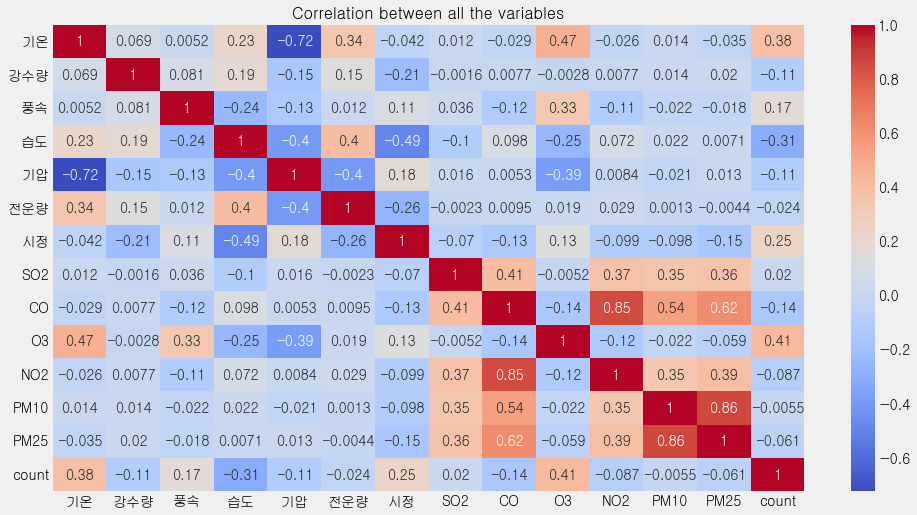

In [18]:
corr_data = df.drop(['날짜','시간','연도','분기','달','요일','주말','휴일'],axis=1)
plt.figure(figsize=(15, 8))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between all the variables', size=16)
plt.show()

In [19]:
# 필요없는 Feature 삭제
deletelist = ["날짜","CO","PM25"]
for i in deletelist:
    df = df.drop(i, axis=1)

In [20]:
df.head()

,시간,기온,강수량,풍속,습도,기압,전운량,시정,SO2,O3,NO2,PM10,count,연도,분기,달,요일,주말,휴일
D-H,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0,-6.5,0.0,0.0,38.0,1022.6,9.0,2000.0,0.004,0.002,0.047,45.0,50.0,2020,1,1,2,weekday,Holidays
2020-01-01 01:00:00,1,-5.9,0.0,1.7,40.0,1021.8,9.0,2000.0,0.004,0.002,0.044,25.0,17.0,2020,1,1,2,weekday,Holidays
2020-01-01 02:00:00,2,-5.7,0.0,0.1,42.0,1021.6,9.0,1988.0,0.004,0.002,0.043,26.0,30.0,2020,1,1,2,weekday,Holidays
2020-01-01 03:00:00,3,-5.6,0.0,0.0,46.0,1021.5,9.0,2000.0,0.004,0.001,0.043,29.0,12.0,2020,1,1,2,weekday,Holidays
2020-01-01 04:00:00,4,-5.4,0.0,0.0,50.0,1021.6,8.0,1908.0,0.003,0.002,0.040,26.0,14.0,2020,1,1,2,weekday,Holidays


### Outlier 처리: 모든 피처들을 고려해 제거할 outlier 행들을 선정
이상치가 12개로 확인

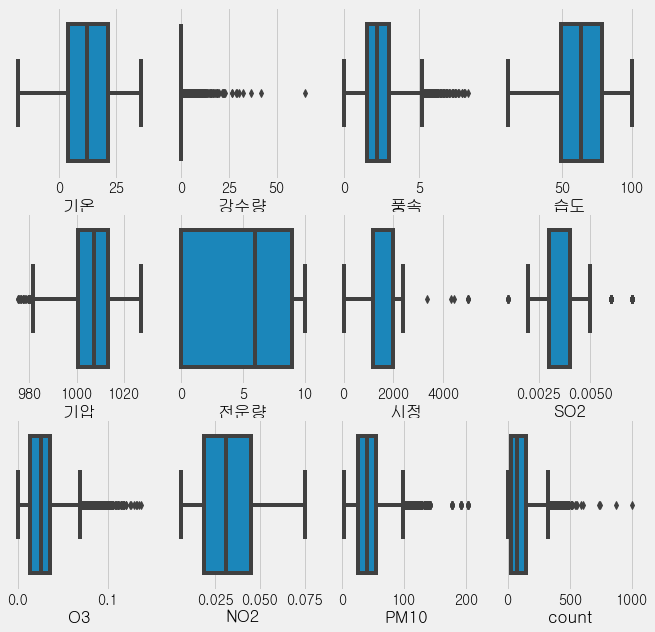

In [21]:
plt.figure(figsize=(10,10))
for index,item in enumerate([i for i in df.drop(['시간','연도','분기','달','요일','주말','휴일'],axis=1)]):
    plt.subplot(3,4,index+1)
    sns.boxplot(df[item])

In [22]:
df.describe()

,시간,기온,강수량,풍속,습도,기압,전운량,시정,SO2,O3,NO2,PM10,count,연도,분기,달,요일
count,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000
mean,11.500000,12.189154,0.149736,2.352421,63.642661,1006.782871,4.888145,1594.400274,0.003686,0.026821,0.032224,42.566540,94.971173,2020.663825,2.342266,6.024361,2.998782
std,6.922362,10.793390,1.273551,1.160825,19.216870,8.162997,4.002293,568.535587,0.000839,0.017893,0.015572,23.207469,83.914318,0.665153,1.154812,3.558805,1.997918
min,0.000000,-18.500000,0.000000,0.000000,11.000000,975.200000,0.000000,33.000000,0.001000,0.000000,0.006000,3.000000,1.000000,2020.000000,1.000000,1.000000,0.000000
25%,5.750000,3.900000,0.000000,1.500000,49.000000,1000.475000,0.000000,1185.000000,0.003000,0.014000,0.019000,26.000000,25.000000,2020.000000,1.000000,3.000000,1.000000
50%,11.500000,12.200000,0.000000,2.200000,64.000000,1007.300000,6.000000,2000.000000,0.004000,0.026000,0.031000,39.000000,72.000000,2021.000000,2.000000,6.000000,3.000000
75%,17.250000,21.500000,0.000000,3.000000,79.000000,1013.100000,9.000000,2000.000000,0.004000,0.036000,0.045000,55.000000,145.000000,2021.000000,3.000000,9.000000,5.000000
max,23.000000,36.300000,64.700000,8.300000,100.000000,1027.200000,10.000000,5000.000000,0.007000,0.137000,0.075000,204.000000,994.000000,2022.000000,4.000000,12.000000,6.000000


In [23]:
from collections import Counter 

def outlier_detecting(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_line = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_line) | (df[col] > Q3 + outlier_line)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        
Outliers_to_drop = outlier_detecting(df, 2, df.describe().columns)
Outliers_to_drop

[Timestamp('2020-06-30 02:00:00'),
 Timestamp('2020-06-30 03:00:00'),
 Timestamp('2020-07-23 17:00:00'),
 Timestamp('2020-07-23 18:00:00'),
 Timestamp('2020-09-03 07:00:00'),
 Timestamp('2020-09-03 08:00:00'),
 Timestamp('2020-09-03 09:00:00'),
 Timestamp('2020-09-07 11:00:00'),
 Timestamp('2020-09-07 12:00:00'),
 Timestamp('2021-08-31 16:00:00'),
 Timestamp('2021-05-13 17:00:00'),
 Timestamp('2021-05-13 18:00:00')]

In [24]:
# 이상치 12개 확인
print(df.shape)
df = df.drop(Outliers_to_drop, axis = 0)
df.shape

(19704, 19)


(19692, 19)

### 범주형 변수 원핫 인코딩

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19692 entries, 2020-01-01 00:00:00 to 2022-03-31 23:00:00
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시간      19692 non-null  int64  
 1   기온      19692 non-null  float64
 2   강수량     19692 non-null  float64
 3   풍속      19692 non-null  float64
 4   습도      19692 non-null  float64
 5   기압      19692 non-null  float64
 6   전운량     19692 non-null  float64
 7   시정      19692 non-null  float64
 8   SO2     19692 non-null  float64
 9   O3      19692 non-null  float64
 10  NO2     19692 non-null  float64
 11  PM10    19692 non-null  float64
 12  count   19692 non-null  float64
 13  연도      19692 non-null  int64  
 14  분기      19692 non-null  int64  
 15  달       19692 non-null  int64  
 16  요일      19692 non-null  int64  
 17  주말      19692 non-null  object 
 18  휴일      19692 non-null  object 
dtypes: float64(12), int64(5), object(2)
memory usage: 3.0+ MB


In [26]:
week_day = pd.get_dummies(df['주말'])
holiday = pd.get_dummies(df['휴일'])

df = pd.concat([df,holiday,week_day],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19692 entries, 2020-01-01 00:00:00 to 2022-03-31 23:00:00
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           19692 non-null  int64  
 1   기온           19692 non-null  float64
 2   강수량          19692 non-null  float64
 3   풍속           19692 non-null  float64
 4   습도           19692 non-null  float64
 5   기압           19692 non-null  float64
 6   전운량          19692 non-null  float64
 7   시정           19692 non-null  float64
 8   SO2          19692 non-null  float64
 9   O3           19692 non-null  float64
 10  NO2          19692 non-null  float64
 11  PM10         19692 non-null  float64
 12  count        19692 non-null  float64
 13  연도           19692 non-null  int64  
 14  분기           19692 non-null  int64  
 15  달            19692 non-null  int64  
 16  요일           19692 non-null  int64  
 17  주말           19692 non-null  object 
 18  휴일         

In [27]:
df.drop(['휴일','주말'],axis=1,inplace=True)

In [28]:
for col in df.describe().columns:
     print('{:15}'.format(col), 
           '왜도: {:05.2f}'.format(df[col].skew()) , 
           '   ' ,
           '첨도: {:06.2f}'.format(df[col].kurt())  
          )

시간              왜도: 00.00     첨도: -01.20
기온              왜도: -0.14     첨도: -00.91
강수량             왜도: 19.57     첨도: 604.90
풍속              왜도: 00.76     첨도: 000.81
습도              왜도: -0.14     첨도: -00.81
기압              왜도: -0.16     첨도: -00.68
전운량             왜도: -0.07     첨도: -01.66
시정              왜도: -0.98     첨도: 000.11
SO2             왜도: 00.37     첨도: 000.20
O3              왜도: 01.01     첨도: 002.02
NO2             왜도: 00.27     첨도: -00.90
PM10            왜도: 01.29     첨도: 004.03
count           왜도: 01.34     첨도: 003.03
연도              왜도: 00.50     첨도: -00.74
분기              왜도: 00.18     첨도: -01.42
달               왜도: 00.17     첨도: -01.27
요일              왜도: 00.00     첨도: -01.25
Holidays        왜도: 04.53     첨도: 018.49
No Holidays     왜도: -4.53     첨도: 018.49
weekday         왜도: -0.95     첨도: -01.09
weekend         왜도: 00.95     첨도: -01.09


### 타겟 데이터 분포 재정립

왜도: 1.340491
첨도: 3.026871


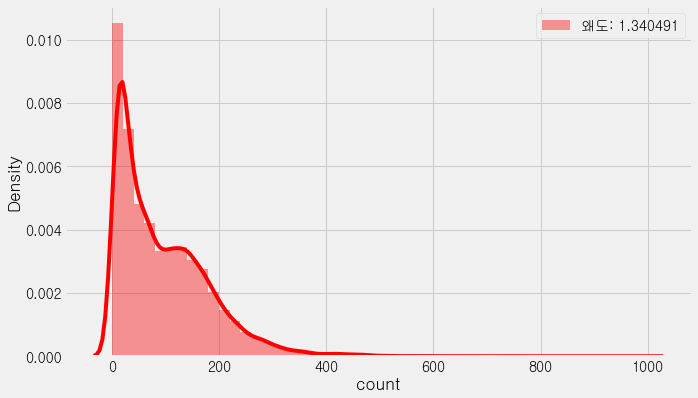

In [29]:
f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df["count"], color = "r", label="왜도: {:2f}".format(df["count"].skew()), ax=ax)
g = g.legend(loc = "best")

print("왜도: %f" % df["count"].skew())
print("첨도: %f" % df["count"].kurt())

Skewness: -0.784624
Kurtosis: 0.186880


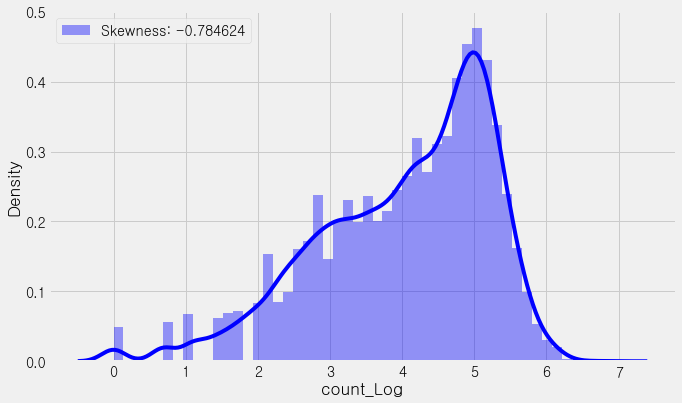

In [30]:
df["count_Log"] = df["count"].map(lambda i:np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df["count_Log"], color = "b", label="Skewness: {:2f}".format(df["count_Log"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % df['count_Log'].skew())
print("Kurtosis: %f" % df['count_Log'].kurt())

df.drop('count', axis= 1, inplace=True)

## Train/Test Split

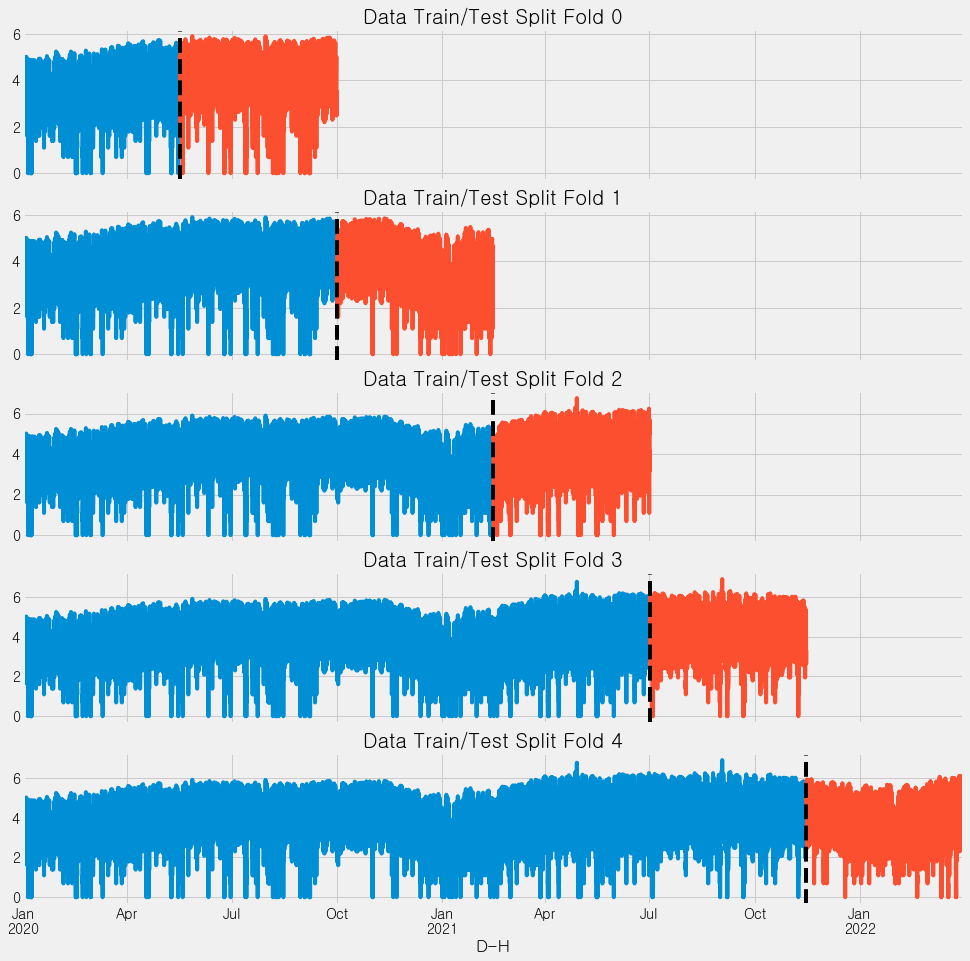

In [31]:
## Train/Test Split
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, gap=24)
df = df.sort_index()
fig, axs = plt.subplots(5,1, figsize=(15,15), sharex=True)

fold= 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['count_Log'].plot(ax=axs[fold],
                       label="Training Set",
                        title=f'Data Train/Test Split Fold {fold}')
    test['count_Log'].plot(ax=axs[fold],
                      label='Test Set')
    axs[fold].axvline(test.index.min(), color='black',ls='--')
    fold +=1

## Xgbregressor

In [32]:
## Modeling + Cross Validation
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

X_train = train.drop(['count_Log'], axis=1)
y_train = train['count_Log']

X_test = test.drop(['count_Log'], axis=1)
y_test = test['count_Log']
    
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                        n_estimators=1000, 
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01)
reg.fit(X_train, y_train,
         eval_set =[(X_train, y_train), (X_test, y_test)],
         verbose=100)

[0]	validation_0-rmse:3.69290	validation_1-rmse:3.69109
[100]	validation_0-rmse:1.49384	validation_1-rmse:1.64651
[200]	validation_0-rmse:0.78248	validation_1-rmse:0.95186
[300]	validation_0-rmse:0.58444	validation_1-rmse:0.72187
[400]	validation_0-rmse:0.52206	validation_1-rmse:0.62766
[500]	validation_0-rmse:0.49379	validation_1-rmse:0.58857
[600]	validation_0-rmse:0.47582	validation_1-rmse:0.57079
[700]	validation_0-rmse:0.46240	validation_1-rmse:0.55889
[800]	validation_0-rmse:0.45289	validation_1-rmse:0.55090
[900]	validation_0-rmse:0.44577	validation_1-rmse:0.54583
[999]	validation_0-rmse:0.43950	validation_1-rmse:0.54283


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Feature Importance

In [33]:
## Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
                 index=reg.get_booster().feature_names,
                 columns=['importance'])

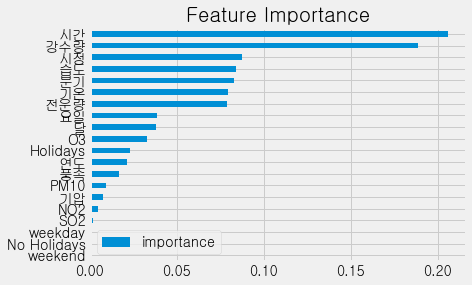

In [34]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

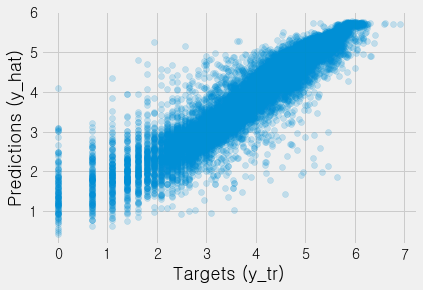

In [35]:
y_hat = reg.predict(X_train)
plt.scatter(y_train, y_hat, alpha = 0.2)
plt.xlabel('Targets (y_tr)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

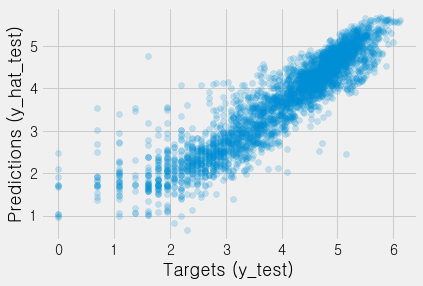

In [36]:
y_hat_test = reg.predict(X_test)
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.show()

## Score

In [37]:
# SCORE: RMSE
test['prediction'] = reg.predict(X_test)
score = np.sqrt(mean_squared_error(test['count_Log'], test['prediction']))
print(f'RMSE Score on Test Set: {score:0.2f}')

RMSE Score on Test Set: 0.54


In [38]:
# SCORE : R2-Score
from sklearn.metrics import r2_score

y_pred_train = reg.predict(X_train)
y_pred = reg.predict(X_test)

r2_score(y_pred_train, y_train)

0.8300719937521854

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred, p = 17):
    
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = mean_squared_error(y_test, y_pred)**0.5
    R2 = r2_score(y_test, y_pred)
    n = len(y_test)
    adjusted_R2 = 1-(1-R2)*(n-1)/(n-p-1)

    Result = pd.DataFrame(data = [MAE, RMSE, adjusted_R2],
                          index= ['MAE', 'RMSE', 'adjusted R2'],
                          columns = ['Result'])
    return Result

In [40]:
confirm_result(y_test, y_pred)

,Result
MAE,0.430927
RMSE,0.542827
adjusted R2,0.768939


## Prediction Plot

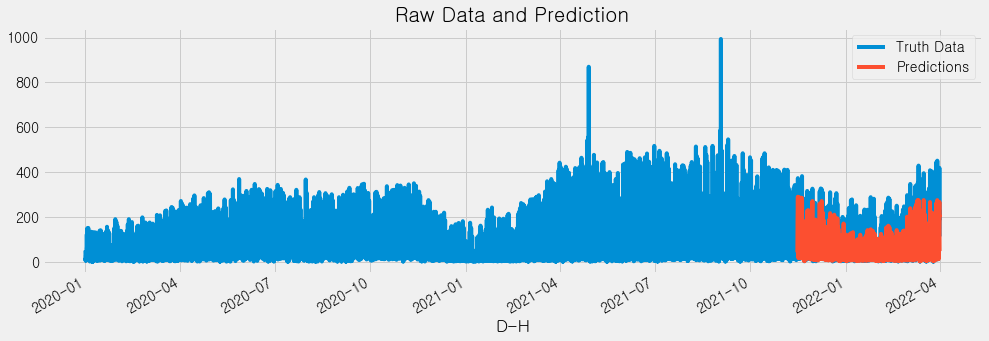

In [41]:
#PLOT
test['prediction'] = np.exp(test['prediction'])
df['count_Log'] = np.exp(df['count_Log'])

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = df[['count_Log']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

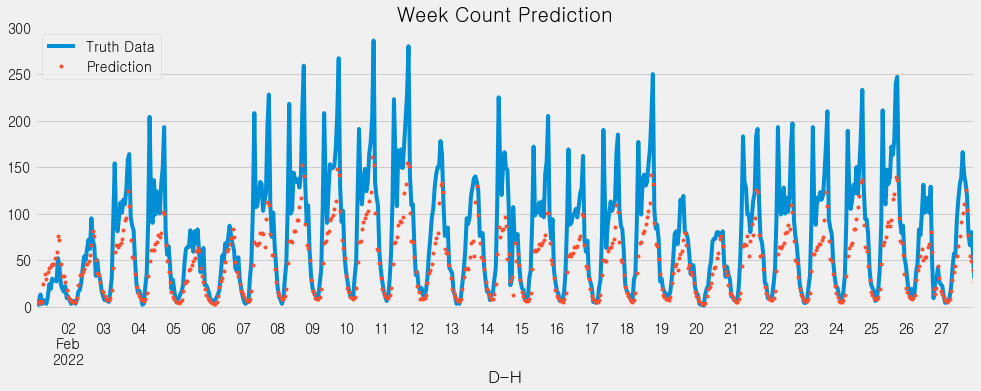

In [42]:
ax = df.loc[(df.index > '2022-02-01') & (df.index < '2022-02-28')]['count_Log'].plot(figsize=(15,5), title="Week Count Prediction")
df.loc[(df.index > '2022-02-01') & (df.index < '2022-02-28')]['prediction'].plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()